In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer import noise
from qiskit_ibm_runtime.fake_provider import FakeGuadalupeV2, FakeAthensV2

# Homemade imports
from qiskit_algorithms import VarQITE, TimeEvolutionProblem
from qiskit_algorithms.gradients import LinCombEstimatorGradient, LinCombQGT
import qiskit_algorithms.time_evolvers.variational.variational_principles.imaginary_mc_lachlan_principle as mc_lachlan
import qiskit.primitives.utils as utils

from qiskit.primitives import Estimator
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector


In [2]:
# Hamiltonian reading
data = np.loadtxt('qubit_hamil_h2.txt', dtype=str) # H2, 0.7A sto6g
paulistrings = data[:,0] 
coefficients = (data[:,1])
#coefficients = [np.real(complex(coeff)) for coeff in coefficients]
coefficiencts = [complex(coeff) for coeff in coefficients]
paulis = list(zip(paulistrings, coefficients))
qubit_op = SparsePauliOp.from_list(paulis)

qubit_op = qubit_op.adjoint()
#print(f"Number of qubits: {qubit_op.num_qubits}")
print(qubit_op)
#qubit_mat = qubit_op.to_matrix()
#print(qubit_mat - qubit_mat.conj().T) # Is non-Hermitian!

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XY', 'YX', 'XX'],
              coeffs=[-1.09284335-0.j        ,  0.42027207-0.j        , -0.42027207-0.j        ,
 -0.01086588-0.j        ,  0.        -0.06359682j,  0.        +0.06359682j,
  0.1576953 -0.j        ])


In [3]:
# Equivalent problem to Hamiltonian
driver = PySCFDriver(
    atom = "H 0 0 0; H 0 0 0.7",
    unit=DistanceUnit.ANGSTROM,
    charge=0,
    spin=0,
    basis='sto6g'
)
problem = driver.run()
h = problem.hamiltonian.second_q_op()

# Mapper
mapper = ParityMapper(num_particles = problem.num_particles)
qubit_op2 = mapper.map(h)
print(qubit_op2)
#qubit_mat = qubit_op2.to_matrix()
#print(qubit_mat - qubit_mat.conj().T) # Is Hermitian!

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.05178903+0.j,  0.4209349 +0.j, -0.4209349 +0.j, -0.01159108+0.j,
  0.17928567+0.j])


In [36]:
# Settings for all estimators
numshots = 10000
seed = 170

# Simple noise model with depolarizing error
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Measurement miss-assignement probabilities
p0given1 = 0.1
p1given0 = 0.05
error_3 = noise.ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
#noise_model.add_all_qubit_readout_error(error_3)

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Estimators
estimator = Estimator(options={'seed': seed})
shot_estimator = Estimator(options={'seed': seed, 'shots': numshots})
noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": numshots},
    transpile_options={"seed_transpiler": seed},
)

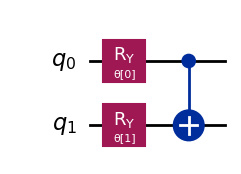

In [9]:
# Ansatz
#ansatz = UCCSD(num_spatial_orbitals = problem.num_spatial_orbitals, num_particles = problem.num_particles, qubit_mapper=mapper)
#init_param_values = [0,3*np.pi/2,-np.pi/2] # surely there should be some systematic way of doing this...
#ansatz.decompose().decompose().decompose().draw("mpl")


ansatz = EfficientSU2(num_qubits = qubit_op2.num_qubits, reps=1, su2_gates=["ry"], skip_final_rotation_layer=True)
init_param_values = [np.pi,np.pi]
ansatz.decompose().draw("mpl")


In [10]:
# Initial state
# hf_state = HartreeFock(num_spatial_orbitals = problem.num_spatial_orbitals, num_particles = problem.num_particles, qubit_mapper=mapper)
# print(hf_state)

# Testing the initial state
print(ansatz.num_parameters)
state = Statevector.from_int(0, 2**qubit_op.num_qubits)
test_circ = ansatz.assign_parameters(init_param_values)
state = state.evolve(test_circ)
state.draw('latex')

2


<IPython.core.display.Latex object>

In [11]:
###############
### VarQITE ###
###############
# This is the TC Hamiltonian with the modified code.

# The 2 main tunable parameters
total_time=5
num_timesteps = 50

var_principle = mc_lachlan.ImaginaryMcLachlanPrinciple(qgt=LinCombQGT(estimator), 
                                                       gradient=LinCombEstimatorGradient(estimator), 
                                                       is_non_hermitian=True)
time_evo = TimeEvolutionProblem(qubit_op, 
                                time=total_time, 
                                aux_operators=[qubit_op])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=estimator, 
               num_timesteps=num_timesteps)
result = qite.evolve(time_evo)

In [12]:
###############
### VarQITE ###
###############
# This is the TC Hamiltonian with the modified code, with shot noise.

# The 2 main tunable parameters
total_time=5
num_timesteps = 50

var_principle = mc_lachlan.ImaginaryMcLachlanPrinciple(qgt=LinCombQGT(shot_estimator), 
                                                       gradient=LinCombEstimatorGradient(shot_estimator), 
                                                       is_non_hermitian=True)
time_evo = TimeEvolutionProblem(qubit_op, 
                                time=total_time, 
                                aux_operators=[qubit_op])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=shot_estimator, 
               num_timesteps=num_timesteps)
result_shotnoise = qite.evolve(time_evo)

In [37]:
###############
### VarQITE ###
###############
# This is the TC Hamiltonian with the modified code, with noise model.

# The 2 main tunable parameters
total_time=5
num_timesteps = 50

var_principle = mc_lachlan.ImaginaryMcLachlanPrinciple(qgt=LinCombQGT(noisy_estimator), 
                                                       gradient=LinCombEstimatorGradient(noisy_estimator), 
                                                       is_non_hermitian=True)
time_evo = TimeEvolutionProblem(qubit_op, 
                                time=total_time, 
                                aux_operators=[qubit_op])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=noisy_estimator, 
               num_timesteps=num_timesteps)
result_noise = qite.evolve(time_evo)

In [14]:
###############
### VarQITE ###
###############
# This is the non-TC Hamiltonian.

# The 2 main tunable parameters
total_time=5
num_timesteps = 50

var_principle = mc_lachlan.ImaginaryMcLachlanPrinciple(qgt=LinCombQGT(estimator), gradient=LinCombEstimatorGradient(estimator))
time_evo = TimeEvolutionProblem(qubit_op2, 
                                time=total_time, 
                                aux_operators=[qubit_op2])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=estimator, 
               num_timesteps=num_timesteps)
result2 = qite.evolve(time_evo)

In [15]:
data = np.loadtxt("energy_trace_h2.dat")
avqite_times = data[:,0]
avqite_energies = data[:,2]
initial_time=data[0,0]
initial_energy=data[0,2]
#print(f"Initial time: {initial_time}, Initial energy: {initial_energy}")

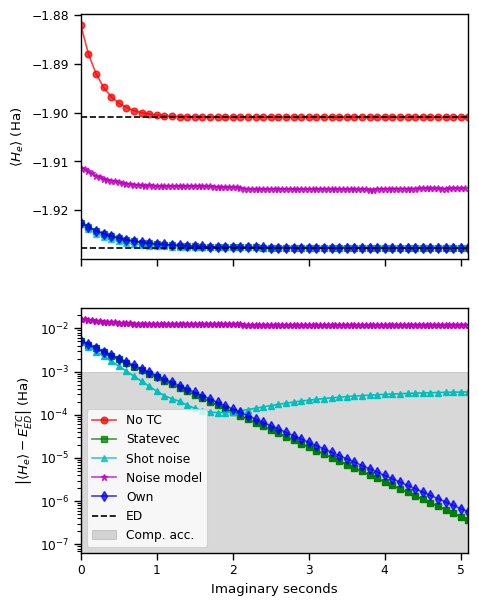

In [38]:
sns.set_context("paper")
fig, axs = plt.subplots(2,1,sharex=True)
fig.set_figheight(7)
fig.set_figwidth(5)
ax = axs[0]
ax2 = axs[1]
#DELTA_BIG = 50
DELTA_BIG = 2
sys = "h2"
e_exact = {"h2": -1.9276748321, "h4": -4.3860854160}
e_exact_notc = {"h2": -1.9009465237, "h4": None} 

h_exp_val = np.array([ele[0][0].real for ele in result.observables])
times = result.times
h_exp_val2 = np.array([ele[0][0].real for ele in result2.observables])
times2 = result2.times
h_exp_val_shotnoise = np.array([ele[0][0].real for ele in result_shotnoise.observables])
times_shotnoise = result_shotnoise.times
h_exp_val_noise = np.array([ele[0][0].real for ele in result_noise.observables])
times_noise = result_noise.times

#print(f"E0_noisy: {h_exp_val_noise[0]}, E0_noTC: {h_exp_val2[0]}, E0_TC: {h_exp_val[0]}")

ax.plot(times2, h_exp_val2, '-ro', label= "No TC", alpha=0.75) #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(times, h_exp_val, '-gs', label= "Statevec", alpha=0.75) #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(times_shotnoise, h_exp_val_shotnoise, '-c^', label= "Shot noise", alpha=0.75) #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(times_noise, h_exp_val_noise, '-m*', label= "Noise model", alpha=0.75) #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(avqite_times[::DELTA_BIG], avqite_energies[::DELTA_BIG], '-bd', label= "Own", alpha=0.75)
ax.plot([e_exact[sys]]*(int(times[-1])+15), '--k', label= "ED")
ax.plot([e_exact_notc[sys]]*(int(times[-1])+15), '--k')
ax.set_ylabel(r"$\langle H_e \rangle$ (Ha)")
#ax.legend()
ax.set_xlim([0, times[-1]])

#print(f"Final Qiskit electronic energy: {h_exp_val[-1]} Ha")
#print(f"Compare with Qutip ED: -4.3860854160 Ha")
#print(f"Compare with TC-VarQITE for UCCSD: -4.3860791082 Ha")


ax2.plot(times, abs(h_exp_val-e_exact[sys]), "-gs", label= "Statevec")
ax2.plot(times_shotnoise, abs(h_exp_val_shotnoise-e_exact[sys]), "-c^", label= "Shot noise")
ax2.plot(times_noise, abs(h_exp_val_noise-e_exact[sys]), "-m*", label= "Noise model")
ax2.plot(avqite_times[::DELTA_BIG], abs(avqite_energies-e_exact[sys])[::DELTA_BIG], "-bd", label= "Own", alpha=0.75)
ax2.fill_between([0,times[-1]],[1e-3,1e-3],color="grey",alpha=0.3,label="Comp. acc.")
ax2.set_xlabel("Imaginary seconds")
ax2.set_ylabel(r"$\left|\langle H_e \rangle - E_{ED}^{TC}\right|$ (Ha)")
ax2.set_yscale("log")
ax2.set_xlim([0, times[-1]])

h, l = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
for index, label in enumerate(l2):
    if label not in l:
        l.append(label)
        h.append(h2[index])
ax2.legend(h, l)


In [ ]:
# Scaled down "realistic" noise model:

device = FakeAthensV2()
coupling_map = device.coupling_map
print('Number of device qubits: ', device.num_qubits)

# Noise model
noise_model = NoiseModel.from_backend(device)

# Alpha: how much to multiply readout fidelity.
alpha = 1
#alpha = 10

# Beta: how much to multiply 1-qubit gate fidelity.
beta = 1
#beta = 10

# Gamma: how much to multiply 2-qubit gate fidelity.
gamma = 1
#gamma = 10

# Noise model
noise_model = NoiseModel.from_backend(device)

# Modify noise models, local quantum errors and readout errors.

# Local quantum errors
for gate in noise_model._local_quantum_errors:
    # Assumes that #possible 2 qubit gates > #qubits. NOT A SAFE ASSUMPTION FOR SMALL DEVICES.
    if len(noise_model._local_quantum_errors[gate].keys()) > device.num_qubits:
        # 2 qubit gates
        print(f"Quantum error for gate {gate}: {noise_model._local_quantum_errors[gate]}")
    else:
        # 1 qubit gates
        #print(f"Quantum error for gate {gate}: {noise_model._local_quantum_errors[gate]}")
        for qubit in noise_model._local_quantum_errors[gate]:
            #print((noise_model._local_quantum_errors[gate][qubit]))
            print((noise_model._local_quantum_errors[gate][qubit]).probabilities)
            #prob_mat = (noise_model._local_quantum_errors[gate][qubit]).probabilities
            #new_prob_mat = np.array([[beta, 1/beta],[1/beta, beta]]) * prob_mat
            #new_prob_mat = new_prob_mat / np.linalg.norm(new_prob_mat, ord=1)
            #noise_model._local_quantum_errors[gate][qubit] = new_prob_mat
            #print(f"Quantum error for gate {gate} on qubit {qubit}: {noise_model._local_quantum_errors[gate][qubit]}")
        #print(noise_model._local_quantum_errors[gate])

# Readout errors
for qubit in noise_model._local_readout_errors:
    prob_mat = (noise_model._local_readout_errors[qubit]).probabilities
    #prob_mat = [[0.9, 0.1], [0.1, 0.9]]
    new_prob_mat = np.array([[alpha, 1/alpha],[1/alpha, alpha]]) * prob_mat
    new_prob_mat = new_prob_mat / np.linalg.norm(new_prob_mat, ord=1)
    noise_model._local_readout_errors[qubit] = new_prob_mat
    #print(f"Readout error for qubit {qubit}: {noise_model._local_readout_errors[qubit]}")


# Noisy estimator
noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": numshots},
    transpile_options={"seed_transpiler": seed},
)